In [188]:
# general libraries
import math, time, random, datetime

# data manipulation libraries
import numpy as np
import pandas as pd

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
plt.style.use('seaborn-whitegrid')

from sklearn.model_selection import GridSearchCV

# Machine learning Algos
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import catboost
from catboost import CatBoostClassifier, Pool, cv


# Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

### Importing the data 

In [383]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
gender_submission = pd.read_csv('data/gender_submission.csv')

In [190]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [191]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [192]:
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [193]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

### Type of data

### The missing values

In [194]:
# counting the missing values
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

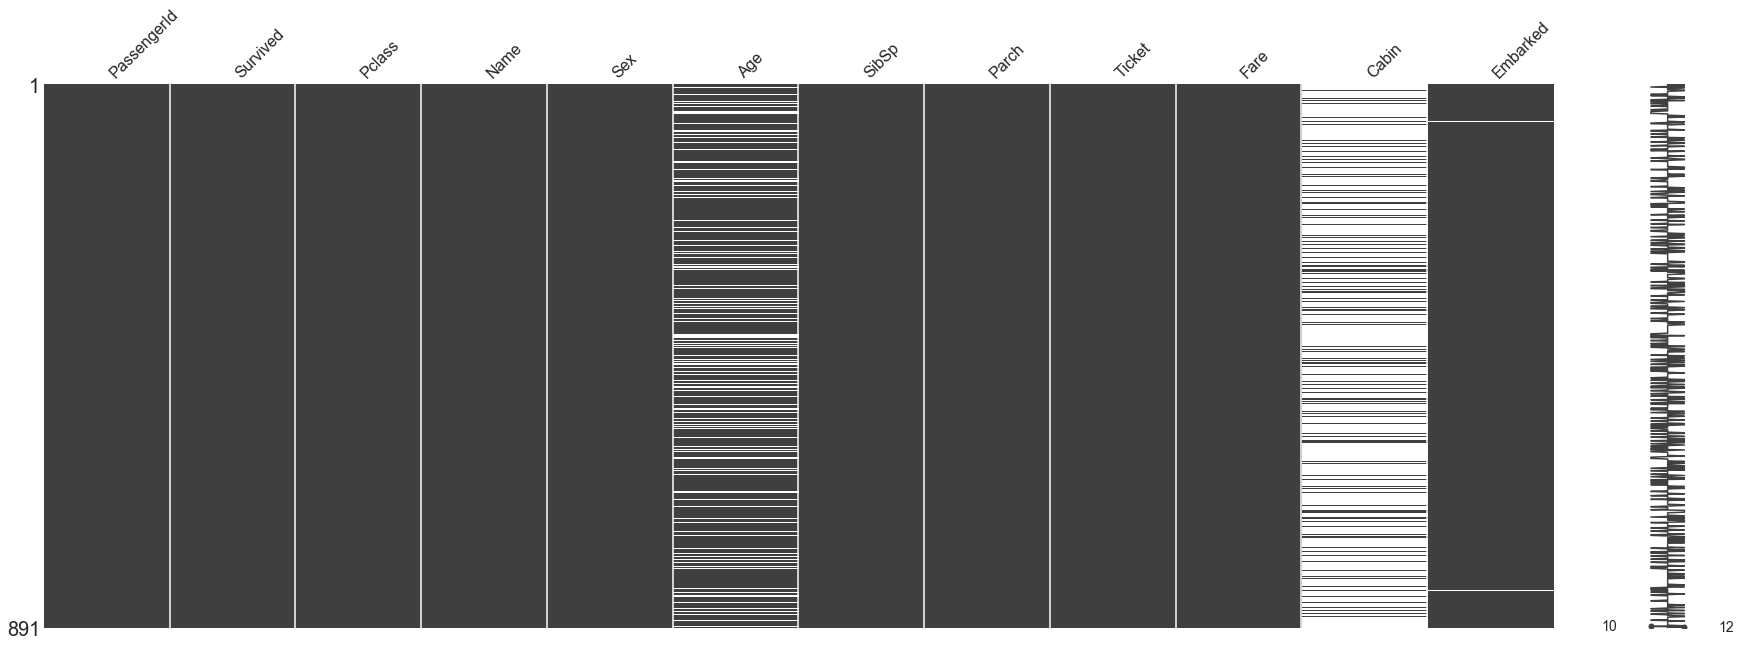

In [195]:
# visualizing the missing values
missingno.matrix(train, figsize = (30,10))

### Now to perform our data analysis we will create two DataFrames

In [196]:
df_bin = pd.DataFrame() # for discretised continuous variables
df_con = pd.DataFrame() # for continuous variables

### Function to create count and distribution visualisations

In [197]:
def plot_count_dist(data, bin_df, label_column, target_column, figsize=(20, 5), use_bin_df=False , use_count=True):
    """
    Function to plot counts and distributions of a label variable and 
    target variable side by side.
    ::param_data:: = target dataframe
    ::param_bin_df:: = binned dataframe for countplot
    ::param_label_column:: = binary labelled column
    ::param_target_column:: = column you want to view counts and distributions
    ::param_figsize:: = size of figure (width, height)
    ::param_use_bin_df:: = whether or not to use the bin_df, default False
    """
    if use_bin_df: 
        fig = plt.figure(figsize=figsize)
        if use_count:
            plt.subplot(1, 2, 1)
            sns.countplot(y=target_column, data=bin_df);
            plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived",'bw':0.1});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive",'bw':0.1});
    else:
        fig = plt.figure(figsize=figsize)
        if use_count:
            plt.subplot(1, 2, 1)
            sns.countplot(y=target_column, data=data);
            plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived",'bw':0.1});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive",'bw':0.1});

## Feature Selection and Feature Engineering

### Feature: PassengerId

Description: Unique ID of the passengers travelling on the ship.

We will ignore this feature as it is of our no use for our prediction

In [198]:
train['PassengerId'].head()

0    1
1    2
2    3
3    4
4    5
Name: PassengerId, dtype: int64

### Feature: Survived 

It is our target variable, lets explore it.

Description: Whether the passenger survived or not.
    
Key: 0 = did not survive, 1 = survived

0    549
1    342
Name: Survived, dtype: int64


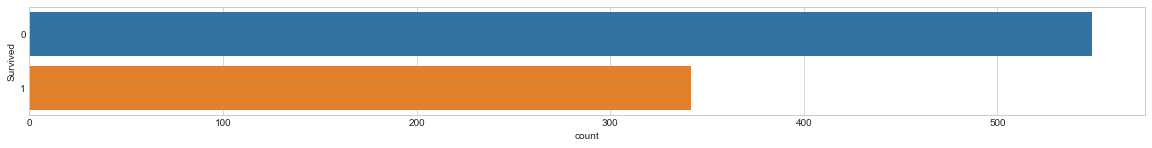

In [199]:
# how many survived, lets visualize it with count plot
fig = plt.figure(figsize=(20,2))
sns.countplot(y='Survived',data=train)
print(train.Survived.value_counts())

In [200]:
# lets add it to our dfs
df_con['Survived']=train['Survived']
df_bin['Survived']=train['Survived']

### Feature: Pclass

Description: The ticket class of the passenger.
    
Key: 1 = 1st, 2 = 2nd, 3 = 3rd

3    491
1    216
2    184
Name: Pclass, dtype: int64


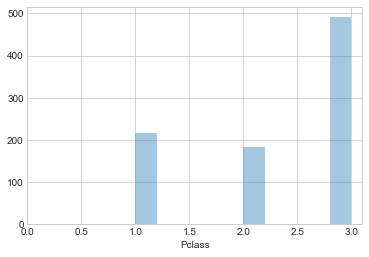

In [201]:
# lets visualize it by distplot
sns.distplot(train.Pclass,kde=False)
plt.xlim(xmin=0)
print(train.Pclass.value_counts())

In [202]:
# How many missing variables does Pclass have?
train.Pclass.isnull().sum()

0

In [203]:
# lets add it to our dfs
df_bin['Pclass'] = train['Pclass']
df_con['Pclass'] = train['Pclass']

### Feature: Name

Description: Name of the passengers 

In [204]:
# checking if missing values
train.Name.isna().sum()

0

In [205]:
# How many different names are there?
train.Name.value_counts()

Zabour, Miss. Hileni                   1
Simmons, Mr. John                      1
Allen, Mr. William Henry               1
Olsen, Mr. Ole Martin                  1
Gallagher, Mr. Martin                  1
                                      ..
Hansen, Mr. Claus Peter                1
Madsen, Mr. Fridtjof Arne              1
Simonius-Blumer, Col. Oberst Alfons    1
Barber, Miss. Ellen "Nellie"           1
Guggenheim, Mr. Benjamin               1
Name: Name, Length: 891, dtype: int64

In [206]:
train.Name.nunique()

891

As all the names are unique, thus we can't do something with them directly.

But what we can do is create a new feature by extracting their Titles or their Last Names

Lets see what we can do:

1) By their Titles

2) By their Last Names 

In [207]:
k=train.Name.str.split()
k

0                           [Braund,, Mr., Owen, Harris]
1      [Cumings,, Mrs., John, Bradley, (Florence, Bri...
2                             [Heikkinen,, Miss., Laina]
3      [Futrelle,, Mrs., Jacques, Heath, (Lily, May, ...
4                          [Allen,, Mr., William, Henry]
                             ...                        
886                            [Montvila,, Rev., Juozas]
887                    [Graham,, Miss., Margaret, Edith]
888       [Johnston,, Miss., Catherine, Helen, "Carrie"]
889                           [Behr,, Mr., Karl, Howell]
890                              [Dooley,, Mr., Patrick]
Name: Name, Length: 891, dtype: object

In [208]:
t=[]
ln=[]
for i in k:
    t.append(i[1])
    ln.append(i[0])

#### Lets explore Titles now

In [209]:
titles=pd.Series(t)
titles.head()

0      Mr.
1     Mrs.
2    Miss.
3     Mrs.
4      Mr.
dtype: object

In [210]:
titles.value_counts()

Mr.             502
Miss.           179
Mrs.            121
Master.          40
Dr.               7
Rev.              6
y                 4
Planke,           3
Impe,             3
Col.              2
Major.            2
Gordon,           2
Mlle.             2
Mulder,           1
Ms.               1
der               1
Don.              1
Messemaeker,      1
Billiard,         1
Mme.              1
Cruyssen,         1
Carlo,            1
Jonkheer.         1
Capt.             1
Steen,            1
the               1
Pelsmaeker,       1
Walle,            1
Shawah,           1
Velde,            1
Melkebeke,        1
dtype: int64

#### So here we will keep the first 4 categories and rest we will make them as Others

In [211]:
for i in range(891):
    if not(titles[i] in ['Mr.','Miss.','Mrs.','Master.']):
        titles[i]='Others.'
titles.value_counts()

Mr.        502
Miss.      179
Mrs.       121
Others.     49
Master.     40
dtype: int64

#### Lets explore Last Names now

In [212]:
last_names=pd.Series(ln)
last_names.head()

0       Braund,
1      Cumings,
2    Heikkinen,
3     Futrelle,
4        Allen,
dtype: object

In [213]:
last_names.value_counts()

Andersson,    9
Sage,         7
Skoog,        6
Johnson,      6
Carter,       6
             ..
Slemen,       1
Hawksford,    1
Bryhl,        1
McDermott,    1
Blackwell,    1
Length: 661, dtype: int64

In [214]:
last_names.nunique()

661

#### As we see there are many uniques values so we will ignore the Last Names

In [215]:
# lets add it to our dfs
df_bin['Titles'] = titles
df_con['Titles'] = titles

### Feature: Sex

Description: The sex of the passenger (male or female).

male      577
female    314
Name: Sex, dtype: int64


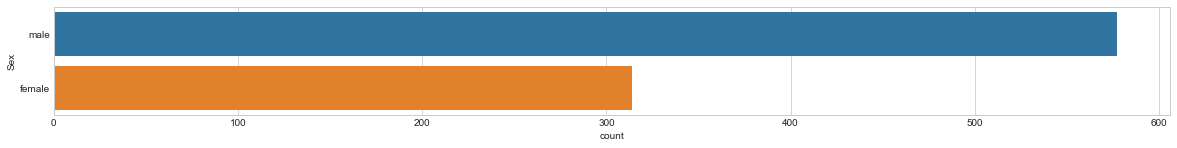

In [216]:
# Let's view the distribution of Sex
plt.figure(figsize=(20, 2))
sns.countplot(y="Sex", data=train)
print(train.Sex.value_counts())

In [217]:
train.Sex.isna().sum()

0

In [218]:
# add Sex to the subset dataframes
df_bin['Sex'] = train['Sex']
df_bin['Sex'] = np.where(df_bin['Sex'] == 'female', 1, 0) # change sex to 0 for male and 1 for female
df_con['Sex'] = train['Sex']

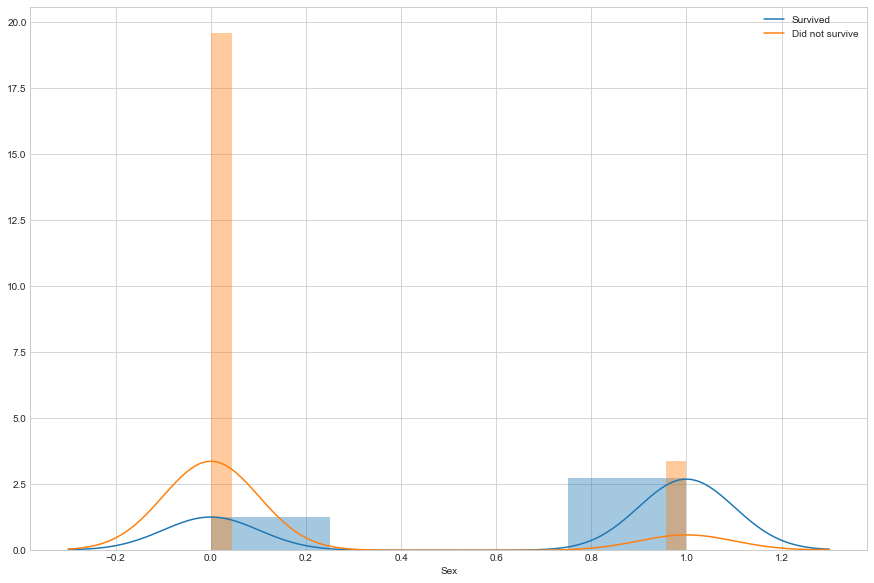

In [219]:
# How does the Sex variable look compared to Survival?
# We can see this because they're both binarys.
# Visualise the counts of Sex and the distribution of the values
# against Survived
plot_count_dist(df_bin, 
               bin_df=df_bin,
                label_column='Survived', 
                target_column='Sex', 
                figsize=(15, 10),
               use_bin_df=True,
               use_count=False)

#### from above we can see that not many people survived. But of those who did, more were female.

### Feature: Age

Description: The age of the passenger.

In [220]:
# How many missing values does age have?
train.Age.isnull().sum()

177

Out of a total 891 rows, that's almost one quarter of the dataset.

What would we do with these missing values?

Could replace them with the average age? What's the pro's and con's of doing this?

Or we can get rid of them completely? But that can affect our prediction as we will be loosing a lot of data

In [221]:
train.Age.value_counts()

24.00    30
22.00    27
18.00    26
19.00    25
30.00    25
         ..
55.50     1
70.50     1
66.00     1
23.50     1
0.42      1
Name: Age, Length: 88, dtype: int64

In [222]:
train.Age.mean()

29.69911764705882

In [223]:
train.Age.median()

28.0

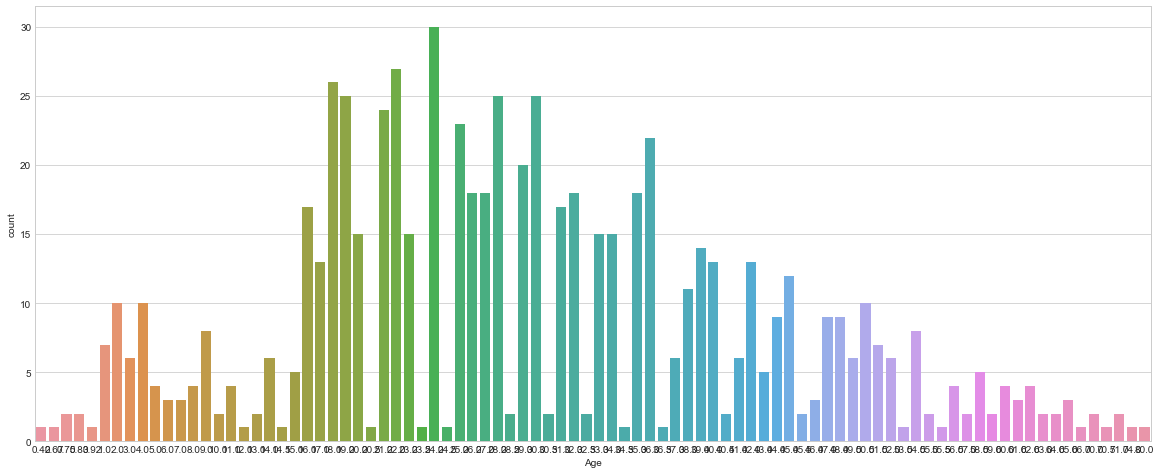

In [224]:
# age countplot
fig = plt.figure(figsize=(20,8))
sns.countplot(x='Age',data=train)

#### Lets try to discretize the age into: 

1) 0 - 20         as 1

2) 21 - 60        as 2

3) 61 - 100       as 3

4) null           as 0

In [225]:
a=[]
for i in train.Age:
    if np.isnan(i):
        a.append(0)
    elif i<21:
        a.append(1)
    elif i<61:
        a.append(2)
    else:
        a.append(3)

In [226]:
discrete_age=pd.DataFrame(a,columns=['Discrete_age'])
discrete_age.Discrete_age.value_counts()

2    512
1    180
0    177
3     22
Name: Discrete_age, dtype: int64

In [227]:
discrete_age = pd.concat([discrete_age,train.Survived,df_bin['Titles']],axis=1)

In [228]:
discrete_age.head()

,Discrete_age,Survived,Titles
0,2,0,Mr.
1,2,1,Mrs.
2,2,1,Miss.
3,2,1,Mrs.
4,2,0,Mr.


#### Now lets see how the survival is distributed among the Discretized Age

#### For the NAN category 0

In [229]:
discrete_age.loc[discrete_age.Discrete_age==0].Survived.value_counts()

0    125
1     52
Name: Survived, dtype: int64

In [230]:
discrete_age.loc[discrete_age.Discrete_age==0].Titles.value_counts()

Mr.        117
Miss.       36
Mrs.        17
Master.      4
Others.      3
Name: Titles, dtype: int64

In [231]:
discrete_age.loc[(discrete_age.Discrete_age==0) & (discrete_age.Survived==1)].Titles.value_counts()

Miss.      22
Mrs.       14
Mr.        13
Master.     2
Others.     1
Name: Titles, dtype: int64

#### For category 1

In [232]:
discrete_age.loc[discrete_age.Discrete_age==1].Survived.value_counts()

0    98
1    82
Name: Survived, dtype: int64

In [233]:
discrete_age.loc[discrete_age.Discrete_age==1].Titles.value_counts()

Miss.      66
Mr.        64
Master.    36
Mrs.        8
Others.     6
Name: Titles, dtype: int64

#### For category 2

In [234]:
discrete_age.loc[discrete_age.Discrete_age==2].Survived.value_counts()

0    309
1    203
Name: Survived, dtype: int64

In [235]:
discrete_age.loc[(discrete_age.Discrete_age==2)].Titles.value_counts()

Mr.        304
Mrs.        94
Miss.       76
Others.     38
Name: Titles, dtype: int64

#### For category 3 

In [236]:
discrete_age.loc[discrete_age.Discrete_age==3].Survived.value_counts()

0    17
1     5
Name: Survived, dtype: int64

In [237]:
discrete_age.loc[(discrete_age.Discrete_age==3)].Titles.value_counts()

Mr.        17
Mrs.        2
Others.     2
Miss.       1
Name: Titles, dtype: int64

#### So now we have seen that the Age with NaN values can be categoried with the help of their Titles

if Master or Miss then put in category 1
else in category 2

In [238]:
def func(x):
    if x in ['Master.','Miss.']:
         return 1
    else:
        return 2

In [239]:
df=discrete_age.loc[discrete_age.Discrete_age==0]
df.Discrete_age=df.Titles.apply(func)
discrete_age.loc[discrete_age.Discrete_age==0]=df

In [240]:
discrete_age.Discrete_age.value_counts()

2    649
1    220
3     22
Name: Discrete_age, dtype: int64

In [241]:
# adding this feature to our dfs
df_bin['Dis_age'] = discrete_age.Discrete_age
df_con['Dis_age'] = discrete_age.Discrete_age

### Feature: SibSp

Description: The number of siblings/spouses the passenger has aboard the Titanic.

In [242]:
# How many missing values does SibSp have?
train.SibSp.isnull().sum()

0

In [243]:
# What values are there?
train.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [244]:
# Add SibSp to subset dataframes
df_bin['SibSp'] = train['SibSp']
df_con['SibSp'] = train['SibSp']

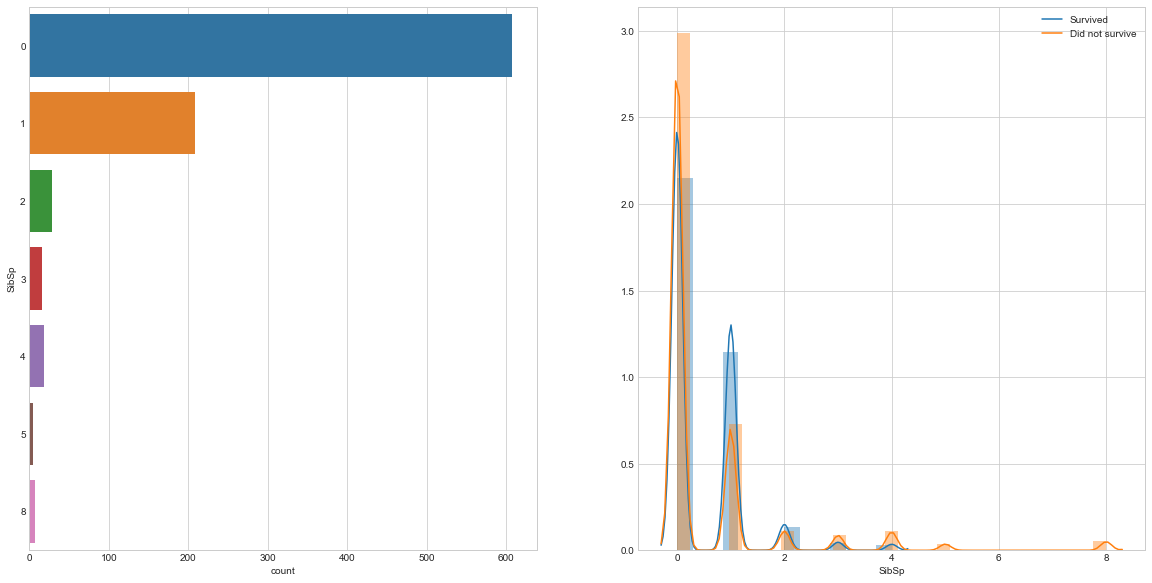

In [245]:
# Visualise the counts of SibSp and the distribution of the values
# against Survived
plot_count_dist(train, 
                bin_df=df_bin, 
                label_column='Survived', 
                target_column='SibSp', 
                figsize=(20, 10))

### Feature: Parch

Description: The number of parents/children the passenger has aboard the Titanic.

In [246]:
# How many missing values does Parch have?
train.Parch.isnull().sum()

0

In [247]:
# What values are there?
train.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [248]:
# Add Parch to subset dataframes
df_bin['Parch'] = train['Parch']
df_con['Parch'] = train['Parch']

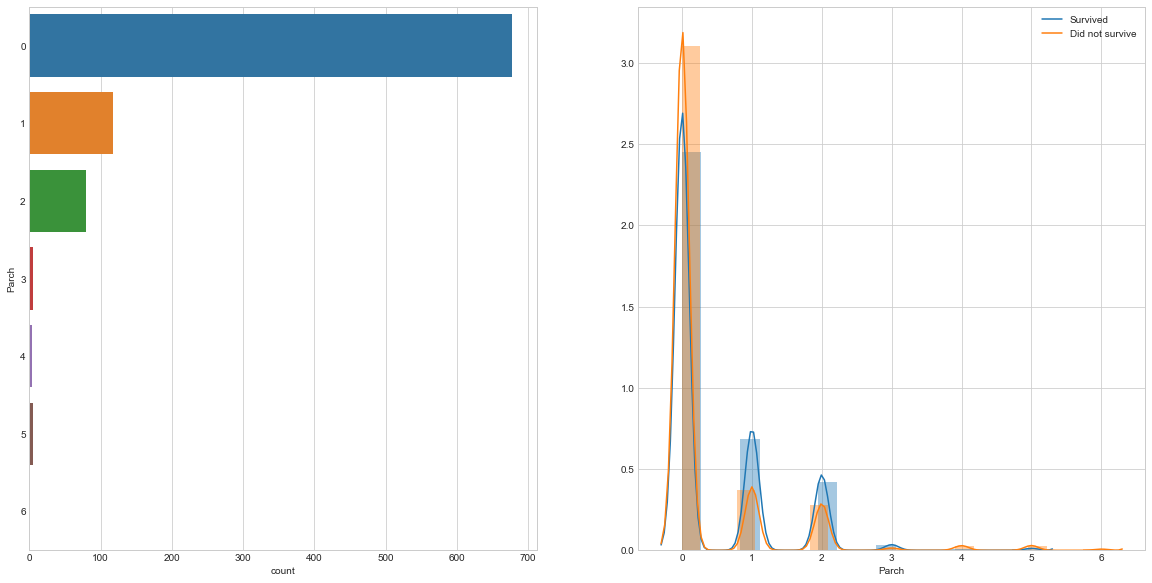

In [249]:
# Visualise the counts of Parch and the distribution of the values
# against Survived
plot_count_dist(train, 
               bin_df=df_bin,
                label_column='Survived', 
                target_column='Parch', 
                figsize=(20, 10))

#### From above two features' graph we can see that majority of the people who had 0 Parch or Sibsp survived

### Feature: Ticket

Description: The ticket number of the boarding passenger.

In [250]:
# How many missing values does Ticket have?
train.Ticket.isnull().sum()

0

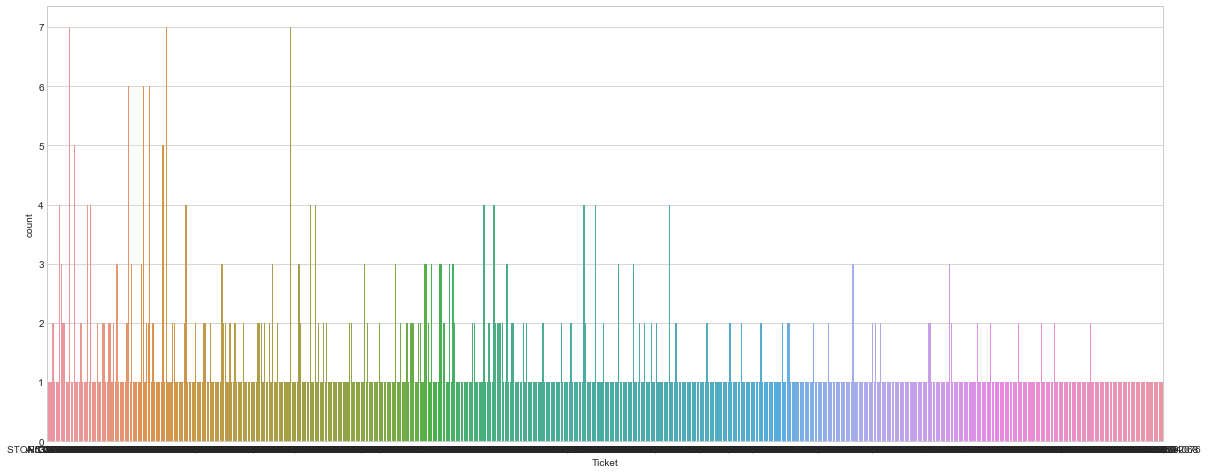

In [251]:
# How many kinds of ticket are there?
fig = plt.figure(figsize=(20,8))
sns.countplot(x="Ticket", data=train);

In [252]:
# How many kinds of ticket are there?
train.Ticket.value_counts()

347082      7
1601        7
CA. 2343    7
3101295     6
347088      6
           ..
367231      1
8475        1
112052      1
350417      1
315153      1
Name: Ticket, Length: 681, dtype: int64

In [253]:
# How many unique kinds of Ticket are there?
train.Ticket.nunique()

681

681 unique values is too many for now. So we won't use `Ticket` in our subset dataframes.

There may be some way to reduce this down. 

### Feature: Fare

Description: How much the ticket cost.

In [254]:
# How many missing values does Fare have?
train.Fare.isnull().sum()

0

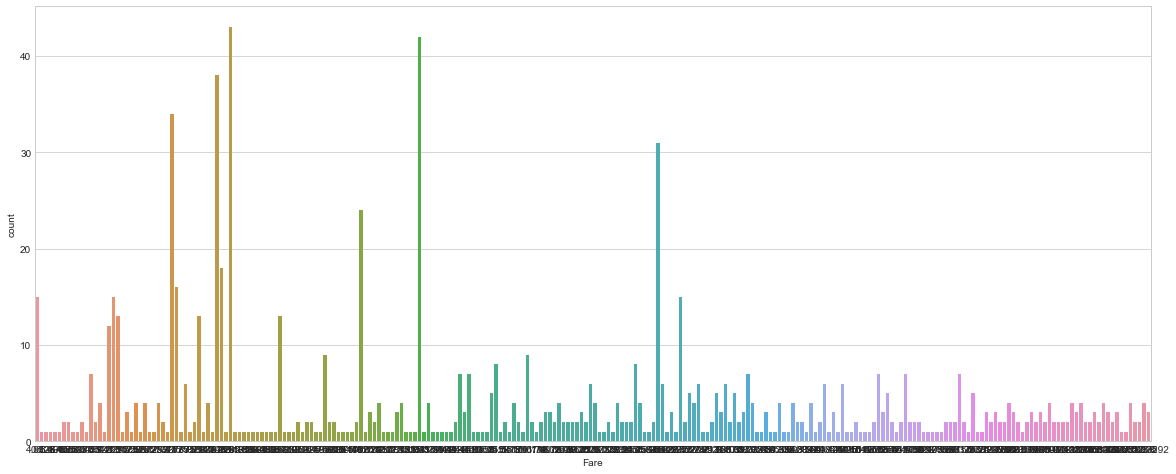

In [255]:
# How many different values of Fare are there?
fig = plt.figure(figsize=(20,8))
sns.countplot(x="Fare", data=train)

In [256]:
# How many kinds of Fare are there?
train.Fare.value_counts()

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
8.4583      1
9.8375      1
8.3625      1
14.1083     1
17.4000     1
Name: Fare, Length: 248, dtype: int64

In [257]:
# How many unique kinds of Fare are there?
train.Fare.nunique()

248

#### Because Fare is a float (number) let's add it as it is to our continuous sub dataframe but to add it to our categorical sub dataframe, we'll cut it into bins.

In [258]:
# Add Fare to sub dataframes
df_con['Fare'] = train['Fare'] 
df_bin['Fare'] = pd.cut(train['Fare'], bins=5) # discretised 

In [259]:
# What do our Fare bins look like?
df_bin.Fare.value_counts()

(-0.512, 102.466]     838
(102.466, 204.932]     33
(204.932, 307.398]     17
(409.863, 512.329]      3
(307.398, 409.863]      0
Name: Fare, dtype: int64

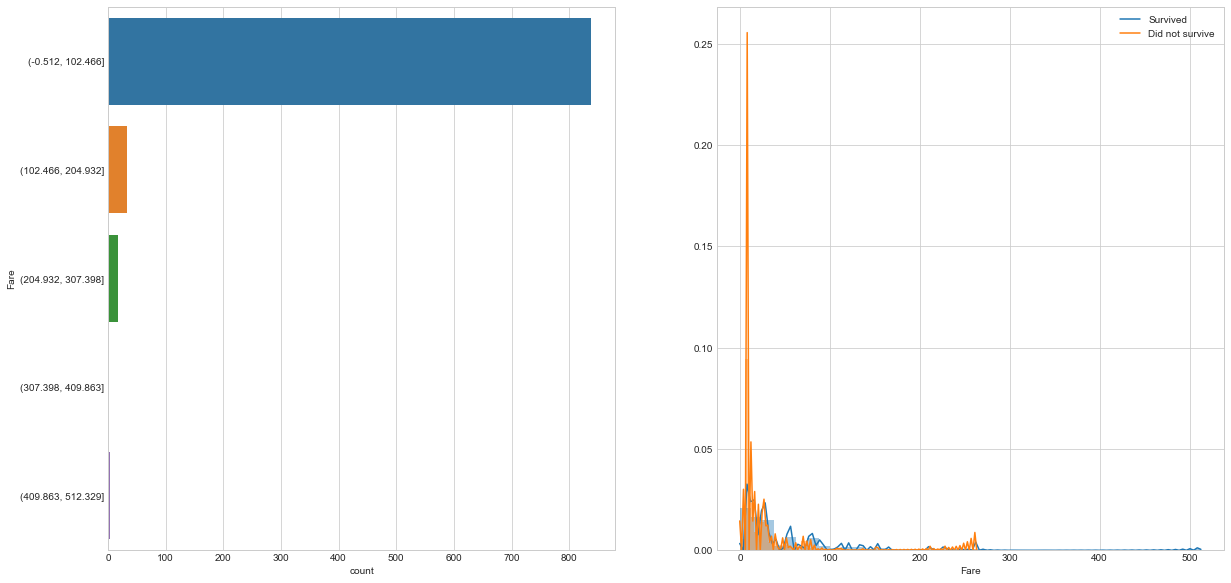

In [260]:
# Visualise the Fare bin counts as well as the Fare distribution versus Survived.
plot_count_dist(data=train,
                bin_df=df_bin,
                label_column='Survived', 
                target_column='Fare', 
                figsize=(20,10), 
                use_bin_df=True)

### Feature: Cabin

Description: The cabin number where the passenger was staying.    

In [261]:
# How many missing values does Cabin have?
train.Cabin.isnull().sum()

687

In [262]:
# What do the Cabin values look like?
train.Cabin.value_counts()

G6             4
B96 B98        4
C23 C25 C27    4
F2             3
C22 C26        3
              ..
A24            1
E58            1
E17            1
C47            1
B42            1
Name: Cabin, Length: 147, dtype: int64

#### Since there are too many missing values, we won't use Cabin for our initial models and won't add it to our sub dataframes.


### Feature: Embarked

Description: The port where the passenger boarded the Titanic.
    
Key: C = Cherbourg, Q = Queenstown, S = Southampton

In [263]:
# How many missing values does Embarked have?
train.Embarked.isnull().sum()

2

In [264]:
# What kind of values are in Embarked?
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

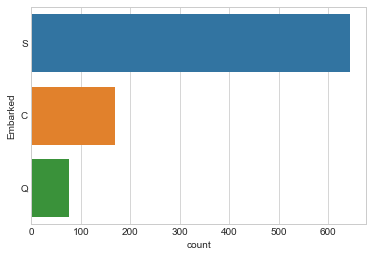

In [265]:
# What do the counts look like?
sns.countplot(y='Embarked', data=train);

In [266]:
train[train.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [267]:
train[(train.Embarked=='S')&(train.Survived==1)].shape

(217, 12)

In [268]:
train[(train.Embarked=='S')&(train.Survived==0)].shape

(427, 12)

In [269]:
train[(train.Embarked=='C')&(train.Survived==1)].shape

(93, 12)

In [270]:
train[(train.Embarked=='C')&(train.Survived==0)].shape

(75, 12)

In [271]:
train[(train.Embarked=='Q')&(train.Survived==1)].shape

(30, 12)

In [272]:
train[(train.Embarked=='Q')&(train.Survived==0)].shape

(47, 12)

In [273]:
# Add Parch to subset dataframes
df_bin['Embarked'] = train['Embarked']
df_con['Embarked'] = train['Embarked']

In [274]:
# Remove Embarked rows which are missing values
print(len(df_con))
df_con = df_con.dropna(subset=['Embarked'])
df_bin = df_bin.dropna(subset=['Embarked'])
print(len(df_con))

891
889


## Feature Encoding
Now we have our two sub dataframes ready. We can encode the features so they're ready to be used with our machine learning models.

We will encode our binned dataframe (`df_bin`) with one-hot encoding and our continuous dataframe (`df_con`) also with one-hot encoding .

In [275]:
df_bin.head()

,Survived,Pclass,Titles,Sex,Dis_age,SibSp,Parch,Fare,Embarked
0,0,3,Mr.,0,2,1,0,"(-0.512, 102.466]",S
1,1,1,Mrs.,1,2,1,0,"(-0.512, 102.466]",C
2,1,3,Miss.,1,2,0,0,"(-0.512, 102.466]",S
3,1,1,Mrs.,1,2,1,0,"(-0.512, 102.466]",S
4,0,3,Mr.,0,2,0,0,"(-0.512, 102.466]",S


In [276]:
# One-hot encode binned variables
one_hot_cols = df_bin.columns.tolist()
one_hot_cols.remove('Survived')
df_bin_enc = pd.get_dummies(df_bin, columns=one_hot_cols)

df_bin_enc.head()

,Survived,Pclass_1,Pclass_2,Pclass_3,Titles_Master.,Titles_Miss.,Titles_Mr.,Titles_Mrs.,Titles_Others.,Sex_0,...,Parch_5,Parch_6,"Fare_(-0.512, 102.466]","Fare_(102.466, 204.932]","Fare_(204.932, 307.398]","Fare_(307.398, 409.863]","Fare_(409.863, 512.329]",Embarked_C,Embarked_Q,Embarked_S
0,0,0,0,1,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,1
1,1,1,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
2,1,0,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,1,1,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0,0,0,1,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,1


In [277]:
df_con.head()

,Survived,Pclass,Titles,Sex,Dis_age,SibSp,Parch,Fare,Embarked
0,0,3,Mr.,male,2,1,0,7.2500,S
1,1,1,Mrs.,female,2,1,0,71.2833,C
2,1,3,Miss.,female,2,0,0,7.9250,S
3,1,1,Mrs.,female,2,1,0,53.1000,S
4,0,3,Mr.,male,2,0,0,8.0500,S


In [278]:
# One hot encode the categorical columns
df_pclass_one_hot = pd.get_dummies(df_con['Pclass'], 
                                   prefix='pclass')

df_titles_one_hot = pd.get_dummies(df_con['Titles'], 
                                   prefix='titles')

df_sex_one_hot = pd.get_dummies(df_con['Sex'], 
                                prefix='sex')

df_age_one_hot = pd.get_dummies(df_con['Dis_age'], 
                                prefix='age')

df_embarked_one_hot = pd.get_dummies(df_con['Embarked'], 
                                     prefix='embarked')

In [279]:
df_con_enc = pd.concat([df_con, 
                        df_pclass_one_hot,
                        df_titles_one_hot,
                        df_sex_one_hot,
                        df_age_one_hot,
                        df_embarked_one_hot 
                        ], axis=1)

# Drop the original categorical columns (because now they've been one hot encoded)
df_con_enc = df_con_enc.drop(['Pclass','Titles', 'Sex', 'Dis_age','Embarked'], axis=1)

In [280]:
# Let's look at df_con_enc
df_con_enc.head()

,Survived,SibSp,Parch,Fare,pclass_1,pclass_2,pclass_3,titles_Master.,titles_Miss.,titles_Mr.,titles_Mrs.,titles_Others.,sex_female,sex_male,age_1,age_2,age_3,embarked_C,embarked_Q,embarked_S
0,0,1,0,7.2500,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1
1,1,1,0,71.2833,1,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0
2,1,0,0,7.9250,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1
3,1,1,0,53.1000,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1
4,0,0,0,8.0500,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1


## Start Building Machine Learning Models
Now our data has been manipulating and converted to numbers, we can run a series of different machine learning algorithms over it to find which yield the best results.

In [281]:
# Seclect the dataframe we want to use first for predictions
selected_df = df_con_enc

In [282]:
selected_df.head()

,Survived,SibSp,Parch,Fare,pclass_1,pclass_2,pclass_3,titles_Master.,titles_Miss.,titles_Mr.,titles_Mrs.,titles_Others.,sex_female,sex_male,age_1,age_2,age_3,embarked_C,embarked_Q,embarked_S
0,0,1,0,7.2500,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1
1,1,1,0,71.2833,1,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0
2,1,0,0,7.9250,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1
3,1,1,0,53.1000,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1
4,0,0,0,8.0500,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1


In [283]:
# Split the dataframe into data and labels
X_train = selected_df.drop('Survived', axis=1) # data
y_train = selected_df.Survived # labels

In [284]:
# Shape of the data (without labels)
X_train.shape

(889, 19)

In [285]:
# Shape of the labels
y_train.shape

(889,)

### Define a function to fit machine learning algorithms
Since many of the algorithms we will use are from the sklearn library, they all take similar (practically the same) inputs and produce similar outputs.

To prevent writing code multiple times, we will functionise fitting the model and returning the accuracy scores.

In [286]:
# Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, params,X_train, y_train, cv):
    
    # One Pass
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    
    clf = GridSearchCV(algo,
                    params,
                    cv=cv,
                    return_train_score=False )

    clf.fit(X_train,y_train)
    
    return acc, clf.best_score_ ,clf.best_params_

### Logistic Regression

In [287]:
# Logistic Regression
start_time = time.time()

C=[0.1, 1 , 10, 20]
solver = ['lbfgs','liblinear']

params = dict(
                C=C,
                solver=solver,
             )

acc_log, acc_cv_log, best_para_log = fit_ml_algo(LogisticRegression(),
                                                  params,
                                                  X_train, 
                                                  y_train, 
                                                  10)

log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print('Best Parameters: %s' % best_para_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))
warnings.filterwarnings('ignore')

Accuracy: 83.69
Accuracy CV 10-Fold: 0.8268003064351379
Best Parameters: {'C': 1, 'solver': 'liblinear'}
Running Time: 0:00:01.371305


### K-Nearest Neighbours

In [288]:
# k-Nearest Neighbours
start_time = time.time()

n_neighbors = [5,10,15, 20]

params = dict(
                n_neighbors=n_neighbors,
             )



acc_knn, acc_cv_knn, best_para_knn = fit_ml_algo(KNeighborsClassifier(), 
                                                  params,
                                                  X_train, 
                                                  y_train, 
                                                  10)

knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print('Best Parameters: %s' % best_para_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 85.49
Accuracy CV 10-Fold: 0.775076608784474
Best Parameters: {'n_neighbors': 5}
Running Time: 0:00:00.403954


### Gaussian Naive Bayes

In [289]:
# Gaussian Naive Bayes
start_time = time.time()

params = dict()

acc_gaussian, acc_cv_gaussian, best_para_gaussian = fit_ml_algo(GaussianNB(), 
                                                                 params,
                                                                 X_train, 
                                                                 y_train, 
                                                                 10)

gaussian_time = (time.time() - start_time)

print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print('Best Parameters: %s' % best_para_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 80.65
Accuracy CV 10-Fold: 0.7997957099080695
Best Parameters: {}
Running Time: 0:00:00.036907


### Support Vector Machines (SVC)

In [290]:
# Support Vector Machine
start_time = time.time()

C=[1,10,20,50,60]

params = dict(
                C=C
             )

acc_svc, acc_cv_svc, best_para_svc = fit_ml_algo(SVC(gamma='auto'),
                                                               params,
                                                               X_train, 
                                                               y_train, 
                                                               10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_svc)
print('Best Parameters: %s' % best_para_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

Accuracy: 83.69
Accuracy CV 10-Fold: 0.8144535240040858
Best Parameters: {'C': 50}
Running Time: 0:00:01.691448


### Stochastic Gradient Descent

In [291]:
# Stochastic Gradient Descent
start_time = time.time()

alpha =[0.0001,0.001,0.1,1]

params = dict(
                alpha=alpha
            )

acc_sgd, acc_cv_sgd, best_para_sgd = fit_ml_algo(SGDClassifier(), 
                                                  params,
                                                  X_train, 
                                                  y_train,
                                                  10)
sgd_time = (time.time() - start_time)
print("Accuracy: %s" % acc_sgd)
print("Accuracy CV 10-Fold: %s" % acc_cv_sgd)
print('Best Parameters: %s' % best_para_sgd)
print("Running Time: %s" % datetime.timedelta(seconds=sgd_time))

Accuracy: 67.83
Accuracy CV 10-Fold: 0.7143769152196118
Best Parameters: {'alpha': 0.001}
Running Time: 0:00:00.245318


### Decision Tree Classifier

In [292]:
# Decision Tree Classifier
start_time = time.time()

max_depth = [5,10,20]

params = dict(max_depth=max_depth)

acc_dt, acc_cv_dt, best_para_dt = fit_ml_algo(DecisionTreeClassifier(), 
                                              params,
                                                                X_train, 
                                                                y_train,
                                                                10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print('Best Parameters: %s' % best_para_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 93.93
Accuracy CV 10-Fold: 0.8200331971399386
Best Parameters: {'max_depth': 5}
Running Time: 0:00:00.140663


### Random Forest Classifier

In [293]:
# Random Forest Classifier
start_time = time.time()

n_estimators=[50,100]
max_depth = [5,10,20]

params = dict(max_depth=max_depth,n_estimators=n_estimators)

acc_rf, acc_cv_rf, best_para_rf = fit_ml_algo(RandomForestClassifier(), 
                                              params,
                                              X_train, 
                                              y_train,
                                              10)

rf_time = (time.time() - start_time)
print("Accuracy: %s" % acc_rf)
print("Accuracy CV 10-Fold: %s" % acc_cv_rf)
print('Best Parameters: %s' % best_para_rf)
print("Running Time: %s" % datetime.timedelta(seconds=rf_time))

Accuracy: 93.93
Accuracy CV 10-Fold: 0.8267747701736464
Best Parameters: {'max_depth': 5, 'n_estimators': 100}
Running Time: 0:00:07.167824


### Gradient Boost Trees

In [294]:
# Gradient Boosting Trees
start_time = time.time()

learning_rate=[0.01,2]
n_estimators=[100]

params = dict(learning_rate=learning_rate,n_estimators=n_estimators)

acc_gbt, acc_cv_gbt, best_para_gbt = fit_ml_algo(GradientBoostingClassifier(), 
                                                  params,
                                                  X_train, 
                                                  y_train,
                                                  10)

gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print('Best Parameters: %s' % best_para_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

Accuracy: 89.43
Accuracy CV 10-Fold: 0.8290347293156282
Best Parameters: {'learning_rate': 0.01, 'n_estimators': 100}
Running Time: 0:00:02.256145


### CatBoost Algorithm
CatBoost is a state-of-the-art open-source gradient boosting on decision trees library.

It's simple and easy to use. And is now regularly one of my go-to algorithms for any kind of machine learning task.

For more on CatBoost and the methods it uses to deal with categorical variables, check out the [CatBoost docs](https://catboost.ai/).

In [295]:
# Define the categorical features for the CatBoost model
cat_features = np.where((X_train.dtypes != np.float) )[0]
cat_features

array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18], dtype=int64)

In [299]:
# Cat Boost Trees
start_time = time.time()

learning_rate=[0.1]
iterations=[100]
depth=[5]

params = dict(learning_rate=learning_rate,iterations=iterations,depth=depth)

acc_cbt, acc_cv_cbt, best_para_cbt = fit_ml_algo(CatBoostClassifier(cat_features=cat_features), 
                                                  params,
                                                  X_train, 
                                                  y_train,
                                                  10)

cbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_cbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_cbt)
print('Best Parameters: %s' % best_para_cbt)
print("Running Time: %s" % datetime.timedelta(seconds=cbt_time))

Learning rate set to 0.009797
0:	learn: 0.6865009	total: 20.8ms	remaining: 20.7s
1:	learn: 0.6826009	total: 32.1ms	remaining: 16s
2:	learn: 0.6760721	total: 47.1ms	remaining: 15.6s
3:	learn: 0.6689518	total: 65.4ms	remaining: 16.3s
4:	learn: 0.6625093	total: 85.9ms	remaining: 17.1s
5:	learn: 0.6592312	total: 90.1ms	remaining: 14.9s
6:	learn: 0.6531639	total: 109ms	remaining: 15.5s
7:	learn: 0.6484440	total: 121ms	remaining: 15s
8:	learn: 0.6433293	total: 142ms	remaining: 15.6s
9:	learn: 0.6376588	total: 158ms	remaining: 15.7s
10:	learn: 0.6331552	total: 163ms	remaining: 14.7s
11:	learn: 0.6283123	total: 173ms	remaining: 14.2s
12:	learn: 0.6230815	total: 189ms	remaining: 14.4s
13:	learn: 0.6177940	total: 196ms	remaining: 13.8s
14:	learn: 0.6143878	total: 202ms	remaining: 13.3s
15:	learn: 0.6098071	total: 207ms	remaining: 12.7s
16:	learn: 0.6062735	total: 219ms	remaining: 12.7s
17:	learn: 0.6010687	total: 229ms	remaining: 12.5s
18:	learn: 0.5979686	total: 237ms	remaining: 12.2s
19:	learn

160:	learn: 0.3986326	total: 1.52s	remaining: 7.95s
161:	learn: 0.3982388	total: 1.53s	remaining: 7.93s
162:	learn: 0.3979332	total: 1.54s	remaining: 7.89s
163:	learn: 0.3975502	total: 1.54s	remaining: 7.86s
164:	learn: 0.3973772	total: 1.55s	remaining: 7.83s
165:	learn: 0.3971300	total: 1.55s	remaining: 7.79s
166:	learn: 0.3967749	total: 1.56s	remaining: 7.81s
167:	learn: 0.3964484	total: 1.58s	remaining: 7.81s
168:	learn: 0.3959009	total: 1.59s	remaining: 7.8s
169:	learn: 0.3953631	total: 1.6s	remaining: 7.8s
170:	learn: 0.3950525	total: 1.6s	remaining: 7.76s
171:	learn: 0.3947287	total: 1.61s	remaining: 7.75s
172:	learn: 0.3942571	total: 1.62s	remaining: 7.73s
173:	learn: 0.3941025	total: 1.63s	remaining: 7.73s
174:	learn: 0.3937037	total: 1.64s	remaining: 7.73s
175:	learn: 0.3933558	total: 1.65s	remaining: 7.71s
176:	learn: 0.3931626	total: 1.65s	remaining: 7.68s
177:	learn: 0.3929493	total: 1.66s	remaining: 7.66s
178:	learn: 0.3925578	total: 1.67s	remaining: 7.66s
179:	learn: 0.39

321:	learn: 0.3644082	total: 2.85s	remaining: 5.99s
322:	learn: 0.3642030	total: 2.85s	remaining: 5.98s
323:	learn: 0.3641168	total: 2.86s	remaining: 5.97s
324:	learn: 0.3639898	total: 2.86s	remaining: 5.95s
325:	learn: 0.3638085	total: 2.87s	remaining: 5.93s
326:	learn: 0.3637592	total: 2.88s	remaining: 5.92s
327:	learn: 0.3637221	total: 2.88s	remaining: 5.9s
328:	learn: 0.3635274	total: 2.89s	remaining: 5.9s
329:	learn: 0.3633952	total: 2.9s	remaining: 5.89s
330:	learn: 0.3633945	total: 2.9s	remaining: 5.86s
331:	learn: 0.3632166	total: 2.9s	remaining: 5.84s
332:	learn: 0.3630556	total: 2.91s	remaining: 5.83s
333:	learn: 0.3628320	total: 2.92s	remaining: 5.81s
334:	learn: 0.3627231	total: 2.92s	remaining: 5.8s
335:	learn: 0.3625827	total: 2.92s	remaining: 5.78s
336:	learn: 0.3625352	total: 2.93s	remaining: 5.77s
337:	learn: 0.3624887	total: 2.94s	remaining: 5.76s
338:	learn: 0.3623515	total: 2.94s	remaining: 5.74s
339:	learn: 0.3622781	total: 2.95s	remaining: 5.73s
340:	learn: 0.3621

486:	learn: 0.3474684	total: 3.93s	remaining: 4.14s
487:	learn: 0.3473075	total: 3.94s	remaining: 4.13s
488:	learn: 0.3472473	total: 3.94s	remaining: 4.12s
489:	learn: 0.3471252	total: 3.95s	remaining: 4.11s
490:	learn: 0.3470872	total: 3.95s	remaining: 4.1s
491:	learn: 0.3469829	total: 3.96s	remaining: 4.09s
492:	learn: 0.3469073	total: 3.98s	remaining: 4.09s
493:	learn: 0.3468354	total: 3.98s	remaining: 4.07s
494:	learn: 0.3467456	total: 3.98s	remaining: 4.07s
495:	learn: 0.3466967	total: 3.99s	remaining: 4.05s
496:	learn: 0.3466952	total: 3.99s	remaining: 4.04s
497:	learn: 0.3465188	total: 4s	remaining: 4.03s
498:	learn: 0.3463931	total: 4.01s	remaining: 4.03s
499:	learn: 0.3463632	total: 4.02s	remaining: 4.02s
500:	learn: 0.3463602	total: 4.02s	remaining: 4s
501:	learn: 0.3461551	total: 4.04s	remaining: 4.01s
502:	learn: 0.3461031	total: 4.05s	remaining: 4s
503:	learn: 0.3460258	total: 4.06s	remaining: 3.99s
504:	learn: 0.3459369	total: 4.06s	remaining: 3.98s
505:	learn: 0.3457697	

667:	learn: 0.3322375	total: 5.2s	remaining: 2.58s
668:	learn: 0.3321897	total: 5.2s	remaining: 2.57s
669:	learn: 0.3321358	total: 5.21s	remaining: 2.56s
670:	learn: 0.3321074	total: 5.22s	remaining: 2.56s
671:	learn: 0.3320818	total: 5.23s	remaining: 2.55s
672:	learn: 0.3320009	total: 5.23s	remaining: 2.54s
673:	learn: 0.3319991	total: 5.23s	remaining: 2.53s
674:	learn: 0.3319991	total: 5.23s	remaining: 2.52s
675:	learn: 0.3319062	total: 5.24s	remaining: 2.51s
676:	learn: 0.3316957	total: 5.26s	remaining: 2.51s
677:	learn: 0.3316957	total: 5.26s	remaining: 2.5s
678:	learn: 0.3315693	total: 5.27s	remaining: 2.49s
679:	learn: 0.3315495	total: 5.27s	remaining: 2.48s
680:	learn: 0.3315141	total: 5.28s	remaining: 2.47s
681:	learn: 0.3314769	total: 5.28s	remaining: 2.46s
682:	learn: 0.3314638	total: 5.29s	remaining: 2.45s
683:	learn: 0.3313840	total: 5.3s	remaining: 2.45s
684:	learn: 0.3312546	total: 5.31s	remaining: 2.44s
685:	learn: 0.3311441	total: 5.32s	remaining: 2.43s
686:	learn: 0.33

844:	learn: 0.3198874	total: 6.49s	remaining: 1.19s
845:	learn: 0.3196209	total: 6.5s	remaining: 1.18s
846:	learn: 0.3195104	total: 6.51s	remaining: 1.18s
847:	learn: 0.3193915	total: 6.52s	remaining: 1.17s
848:	learn: 0.3193605	total: 6.53s	remaining: 1.16s
849:	learn: 0.3193515	total: 6.53s	remaining: 1.15s
850:	learn: 0.3193424	total: 6.54s	remaining: 1.14s
851:	learn: 0.3192777	total: 6.54s	remaining: 1.14s
852:	learn: 0.3192411	total: 6.56s	remaining: 1.13s
853:	learn: 0.3191371	total: 6.58s	remaining: 1.12s
854:	learn: 0.3190892	total: 6.59s	remaining: 1.12s
855:	learn: 0.3190618	total: 6.6s	remaining: 1.11s
856:	learn: 0.3189724	total: 6.63s	remaining: 1.11s
857:	learn: 0.3189235	total: 6.64s	remaining: 1.1s
858:	learn: 0.3188276	total: 6.66s	remaining: 1.09s
859:	learn: 0.3187490	total: 6.67s	remaining: 1.09s
860:	learn: 0.3187015	total: 6.68s	remaining: 1.08s
861:	learn: 0.3185409	total: 6.7s	remaining: 1.07s
862:	learn: 0.3184806	total: 6.72s	remaining: 1.07s
863:	learn: 0.31

0:	learn: 0.6598276	total: 5.64ms	remaining: 559ms
1:	learn: 0.6268758	total: 11.4ms	remaining: 560ms
2:	learn: 0.6000058	total: 16.9ms	remaining: 545ms
3:	learn: 0.5752116	total: 18.4ms	remaining: 443ms
4:	learn: 0.5601594	total: 19.3ms	remaining: 367ms
5:	learn: 0.5423953	total: 20.8ms	remaining: 326ms
6:	learn: 0.5261258	total: 22.3ms	remaining: 296ms
7:	learn: 0.5110640	total: 24.3ms	remaining: 280ms
8:	learn: 0.5008231	total: 25.8ms	remaining: 261ms
9:	learn: 0.4904322	total: 27.3ms	remaining: 246ms
10:	learn: 0.4793791	total: 28.9ms	remaining: 234ms
11:	learn: 0.4711352	total: 30.4ms	remaining: 223ms
12:	learn: 0.4649809	total: 31.9ms	remaining: 214ms
13:	learn: 0.4575883	total: 33.5ms	remaining: 206ms
14:	learn: 0.4498357	total: 35ms	remaining: 198ms
15:	learn: 0.4459254	total: 36.5ms	remaining: 192ms
16:	learn: 0.4398206	total: 38.1ms	remaining: 186ms
17:	learn: 0.4358430	total: 39.6ms	remaining: 181ms
18:	learn: 0.4317015	total: 41.1ms	remaining: 175ms
19:	learn: 0.4289411	tot

81:	learn: 0.3556089	total: 173ms	remaining: 37.9ms
82:	learn: 0.3552319	total: 175ms	remaining: 35.8ms
83:	learn: 0.3550616	total: 177ms	remaining: 33.7ms
84:	learn: 0.3549944	total: 179ms	remaining: 31.6ms
85:	learn: 0.3546977	total: 181ms	remaining: 29.4ms
86:	learn: 0.3546399	total: 183ms	remaining: 27.3ms
87:	learn: 0.3541267	total: 185ms	remaining: 25.2ms
88:	learn: 0.3537241	total: 186ms	remaining: 23ms
89:	learn: 0.3535632	total: 189ms	remaining: 21ms
90:	learn: 0.3533315	total: 192ms	remaining: 19ms
91:	learn: 0.3528839	total: 194ms	remaining: 16.9ms
92:	learn: 0.3527505	total: 196ms	remaining: 14.7ms
93:	learn: 0.3525987	total: 198ms	remaining: 12.6ms
94:	learn: 0.3525148	total: 200ms	remaining: 10.5ms
95:	learn: 0.3519582	total: 202ms	remaining: 8.41ms
96:	learn: 0.3516058	total: 204ms	remaining: 6.31ms
97:	learn: 0.3514508	total: 206ms	remaining: 4.2ms
98:	learn: 0.3505830	total: 208ms	remaining: 2.1ms
99:	learn: 0.3496429	total: 210ms	remaining: 0us
0:	learn: 0.6634564	tot

74:	learn: 0.3785863	total: 160ms	remaining: 53.3ms
75:	learn: 0.3778978	total: 162ms	remaining: 51.2ms
76:	learn: 0.3776064	total: 164ms	remaining: 49ms
77:	learn: 0.3775615	total: 165ms	remaining: 46.5ms
78:	learn: 0.3774211	total: 167ms	remaining: 44.3ms
79:	learn: 0.3769802	total: 169ms	remaining: 42.1ms
80:	learn: 0.3768188	total: 170ms	remaining: 40ms
81:	learn: 0.3766277	total: 175ms	remaining: 38.3ms
82:	learn: 0.3757463	total: 179ms	remaining: 36.6ms
83:	learn: 0.3756726	total: 183ms	remaining: 34.8ms
84:	learn: 0.3755821	total: 186ms	remaining: 32.9ms
85:	learn: 0.3753155	total: 190ms	remaining: 30.9ms
86:	learn: 0.3749295	total: 194ms	remaining: 29ms
87:	learn: 0.3748525	total: 197ms	remaining: 26.8ms
88:	learn: 0.3746658	total: 199ms	remaining: 24.6ms
89:	learn: 0.3743297	total: 202ms	remaining: 22.4ms
90:	learn: 0.3742659	total: 205ms	remaining: 20.2ms
91:	learn: 0.3740081	total: 208ms	remaining: 18.1ms
92:	learn: 0.3735019	total: 210ms	remaining: 15.8ms
93:	learn: 0.37341

0:	learn: 0.6617776	total: 5.26ms	remaining: 520ms
1:	learn: 0.6281587	total: 10.8ms	remaining: 529ms
2:	learn: 0.6008092	total: 15.4ms	remaining: 499ms
3:	learn: 0.5784196	total: 17.1ms	remaining: 410ms
4:	learn: 0.5626125	total: 18ms	remaining: 343ms
5:	learn: 0.5442157	total: 19.7ms	remaining: 309ms
6:	learn: 0.5263414	total: 21.3ms	remaining: 284ms
7:	learn: 0.5105485	total: 23.3ms	remaining: 268ms
8:	learn: 0.4998939	total: 25.1ms	remaining: 253ms
9:	learn: 0.4872413	total: 26.8ms	remaining: 241ms
10:	learn: 0.4755149	total: 28.5ms	remaining: 230ms
11:	learn: 0.4677845	total: 30.3ms	remaining: 222ms
12:	learn: 0.4613892	total: 31.9ms	remaining: 214ms
13:	learn: 0.4545101	total: 33.6ms	remaining: 207ms
14:	learn: 0.4489038	total: 35.4ms	remaining: 200ms
15:	learn: 0.4444791	total: 37.2ms	remaining: 195ms
16:	learn: 0.4379975	total: 38.9ms	remaining: 190ms
17:	learn: 0.4353477	total: 40.6ms	remaining: 185ms
18:	learn: 0.4316919	total: 42.3ms	remaining: 180ms
19:	learn: 0.4285959	tot

0:	learn: 0.6568557	total: 6.81ms	remaining: 674ms
1:	learn: 0.6263296	total: 12.2ms	remaining: 596ms
2:	learn: 0.6007111	total: 14.2ms	remaining: 458ms
3:	learn: 0.5763008	total: 16.5ms	remaining: 397ms
4:	learn: 0.5604433	total: 18.3ms	remaining: 347ms
5:	learn: 0.5412645	total: 19.9ms	remaining: 312ms
6:	learn: 0.5248695	total: 21.6ms	remaining: 286ms
7:	learn: 0.5103739	total: 23.3ms	remaining: 268ms
8:	learn: 0.4991950	total: 25.3ms	remaining: 256ms
9:	learn: 0.4903316	total: 27.6ms	remaining: 248ms
10:	learn: 0.4801281	total: 30.4ms	remaining: 246ms
11:	learn: 0.4728511	total: 32.9ms	remaining: 241ms
12:	learn: 0.4672377	total: 35ms	remaining: 234ms
13:	learn: 0.4608620	total: 37.3ms	remaining: 229ms
14:	learn: 0.4554578	total: 39.6ms	remaining: 224ms
15:	learn: 0.4520170	total: 50.8ms	remaining: 267ms
16:	learn: 0.4475049	total: 52.6ms	remaining: 257ms
17:	learn: 0.4428789	total: 54.3ms	remaining: 247ms
18:	learn: 0.4406941	total: 56.3ms	remaining: 240ms
19:	learn: 0.4368471	tot

97:	learn: 0.3752899	total: 189ms	remaining: 3.86ms
98:	learn: 0.3751498	total: 191ms	remaining: 1.93ms
99:	learn: 0.3751486	total: 193ms	remaining: 0us
Accuracy: 85.94
Accuracy CV 10-Fold: 0.8324182839632277
Best Parameters: {'depth': 5, 'iterations': 100, 'learning_rate': 0.1}
Running Time: 0:00:12.475403


In [300]:
# Print out the CatBoost model metrics
print("---CatBoost Metrics---")
print("Accuracy: {}".format(acc_catboost))
print("Accuracy cross-validation 10-Fold: {}".format(acc_cv_cbt))
print("Running Time: {}".format(datetime.timedelta(seconds=cbt_time)))

---CatBoost Metrics---
Accuracy: 85.94
Accuracy cross-validation 10-Fold: 0.8324182839632277
Running Time: 0:00:12.475403


## Model Results
Which model had the best cross-validation accuracy?

**Note:** We care most about cross-validation metrics because the metrics we get from `.fit()` can randomly score higher than usual.

In [301]:
cv_models = pd.DataFrame({
    'Model': ['Logistic Regression',
              'KNN', 
              'Naive Bayes', 
              'SVC',
              'Stochastic Gradient Decent', 
              'Decision Tree',
              'Random Forest',
              'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_cv_log,
         acc_cv_knn, 
        acc_cv_gaussian,
        acc_cv_svc,
        acc_cv_sgd, 
        acc_cv_dt,
        acc_cv_rf,
        acc_cv_gbt,
        acc_cv_catboost/100
    ]})
print('---Cross-validation Accuracy Scores---')
cv_models.sort_values(by='Score', ascending=False)

---Cross-validation Accuracy Scores---


,Model,Score
8,CatBoost,0.832300
7,Gradient Boosting Trees,0.829035
0,Logistic Regression,0.826800
6,Random Forest,0.826775
5,Decision Tree,0.820033
3,SVC,0.814454
2,Naive Bayes,0.799796
1,KNN,0.775077
4,Stochastic Gradient Decent,0.714377


We can see from the tables, the CatBoost model had the best results. Getting just under 83% is pretty good considering guessing would result in about 50% accuracy (0 or 1).

We'll pay more attention to the cross-validation figure.

Cross-validation is more robust than just the `.fit()` models as it does multiple passes over the data instead of one.

Because the CatBoost model got the best results, we'll use it for the next steps.

## Feature Importance
Which features of the best model were most important for making predictions?

In [302]:
# Feature Importance
def feature_importance(model, data):
    """
    Function to show which features are most important in the model.
    ::param_model:: Which model to use?
    ::param_data:: What data to use?
    """
    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True,False]).iloc[-30:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
    return fea_imp
    #plt.savefig('catboost_feature_importance.png') 

In [303]:
# CatBoost model definition
catboost_model = CatBoostClassifier(cat_features=cat_features,
                                    learning_rate=0.1,
                                    iterations=100,
                                    depth=5)

# Fit CatBoost model
catboost_model.fit(train_pool,verbose=False)

,imp,col
15,0.335292,age_3
7,0.392289,titles_Miss.
9,0.433848,titles_Mrs.
17,0.536151,embarked_Q
13,0.651362,age_1
10,1.268068,titles_Others.
16,1.412099,embarked_C
18,1.434100,embarked_S
14,1.453870,age_2
1,2.685323,Parch


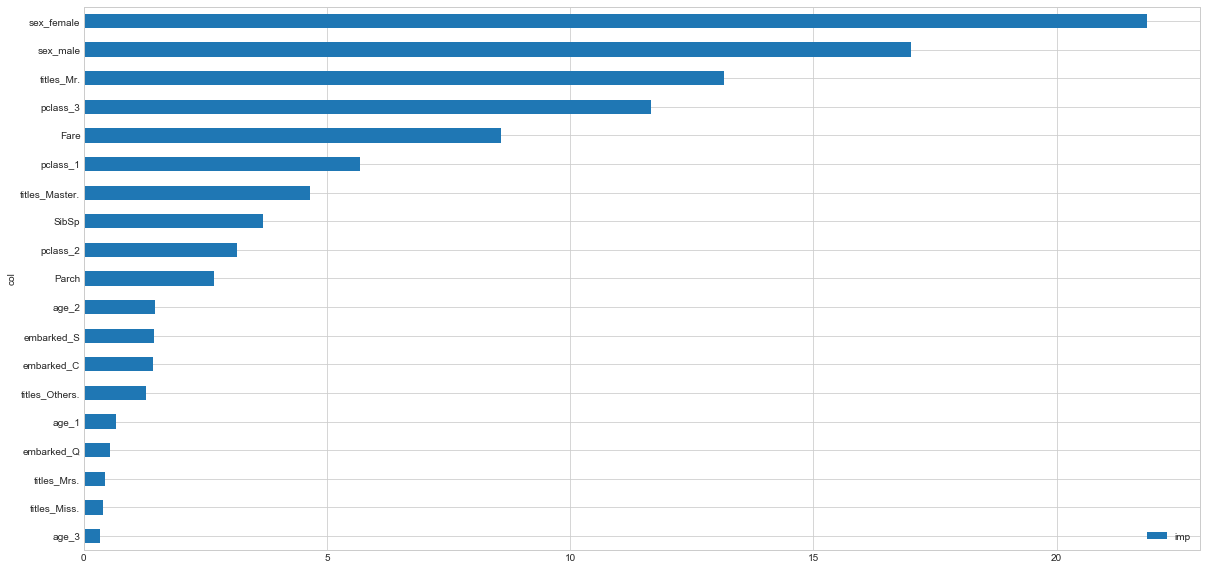

In [304]:
# Plot the feature importance scores
feature_importance(catboost_model, X_train)

#### Why would you want feature importance?

Featrue importance shows how much each feature contributed to the model.

You could take this information and remove features which don't contribute much to reduce dimenstionality (and save compute).

You could improve features which don't offer much to the overall model.

Or you could improve features which offer more to the model. In this case, there aren't many ways you could improve sex as it's already a binary.

Feature importance figures also show people who may not be familiar with the problem what features of their data are most important when it comes to making predictions with machine learning models.

## Precision and Recall

Precision and recall are two metrics which are used for cases where you have have an imbalanced classification problem.

For example, you may have 100,000 people and only 1 of them gets a certain disease. If your model predicts that all people don't have the disease, it only misses 1 in 100,000 so its accuracy is 99.999%. But this isn't really helpful.

This is where precision an recall come in.

**Recall** = a metric which measures a models ability to find all the relevant cases in a dataset.

Recall would be the models ability to find the 1 person in 100,000 who has the disease.

**Precision** = a metric which measures a models ability to correctly identify only relevant instances.

In our example, Precision would be if the model found the 1 person who had the disease, did they actually have the disease.

Combining the precision and recall, gives an **F1 score.**

These metrics will all fall between 0 and 1, with a higher value being better.

Although, they don't necessarily need to come into play for our Titantic problem, they're worth remembering for your future work.

In [306]:
metrics = ['Precision', 'Recall', 'F1', 'AUC']

eval_metrics = catboost_model.eval_metrics(train_pool,
                                           metrics=metrics)

for metric in metrics:
    print(str(metric)+": {}".format(np.mean(eval_metrics[metric])))

Precision: 0.8490966210696468
Recall: 0.7074999999999999
F1: 0.7716960321022494
AUC: 0.8847515536269154


Recall is low, this means there's a higher amount of false negatives (predicting Did not survive when it was actually Survived).

Precision is higher therefore there's less false positives (predicting Survived, when it was actually Did not survive).

## Submission
Let's use the model with the highest cross-validation accuracy score to make a prediction on the test dataset and then submit our predictions to Kaggle.

We want to make predictions on the same kind of columnns our model is trained on.

So we have to select the subset of right columns of the `test` dateframe, encode them and make a prediciton with our model.

In [384]:
# We need our test dataframe to look like this one
X_train.head()

,SibSp,Parch,Fare,pclass_1,pclass_2,pclass_3,titles_Master.,titles_Miss.,titles_Mr.,titles_Mrs.,titles_Others.,sex_female,sex_male,age_1,age_2,age_3,embarked_C,embarked_Q,embarked_S
0,1,0,7.2500,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1
1,1,0,71.2833,1,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0
2,0,0,7.9250,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1
3,1,0,53.1000,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1
4,0,0,8.0500,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1


In [ ]:
test.head()

In [386]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### We are going to add feature to our df_test and tackle all the feature like we had tackle in train dataset

In [387]:
df_test=pd.DataFrame()
df_test['Pclass']=test['Pclass']

In [388]:
k=test.Name.str.split()
t_test=[]
for i in k:
    t_test.append(i[1])
titles_test=pd.Series(t_test)
for i in range(len(titles_test)):
    if not(titles_test[i] in ['Mr.','Miss.','Mrs.','Master.']):
        titles_test[i]='Others.'
df_test['Titles']=titles_test

In [389]:
df_test['Sex']=test['Sex']

In [390]:
a=[]
for i in test.Age:
    if np.isnan(i):
        a.append(0)
    elif i<21:
        a.append(1)
    elif i<61:
        a.append(2)
    else:
        a.append(3)
discrete_age=pd.DataFrame(a,columns=['Discrete_age'])
discrete_age = pd.concat([discrete_age,df_test['Titles']],axis=1)

In [391]:
df=discrete_age.loc[discrete_age.Discrete_age==0]
df.Discrete_age=df.Titles.apply(func)
discrete_age.loc[discrete_age.Discrete_age==0]=df
df_test['Dis_age'] = discrete_age.Discrete_age

In [392]:
df_test['SibSp']=test['SibSp']
df_test['Parch']=test['Parch']

In [393]:
test.loc[test.Fare.isna(),'Fare']=10

In [394]:
df_test['Fare']=test['Fare']
df_test['Embarked']=test['Embarked']

In [395]:
df_test.head()

,Pclass,Titles,Sex,Dis_age,SibSp,Parch,Fare,Embarked
0,3,Mr.,male,2,0,0,7.8292,Q
1,3,Mrs.,female,2,1,0,7.0000,S
2,2,Mr.,male,3,0,0,9.6875,Q
3,3,Mr.,male,2,0,0,8.6625,S
4,3,Mrs.,female,2,1,1,12.2875,S


In [396]:
# One hot encode the categorical columns
df_pclass_one_hot = pd.get_dummies(df_test['Pclass'], 
                                   prefix='pclass')

df_titles_one_hot = pd.get_dummies(df_test['Titles'], 
                                   prefix='titles')

df_sex_one_hot = pd.get_dummies(df_test['Sex'], 
                                prefix='sex')

df_age_one_hot = pd.get_dummies(df_test['Dis_age'], 
                                prefix='age')

df_embarked_one_hot = pd.get_dummies(df_test['Embarked'], 
                                     prefix='embarked')


df_test_enc = pd.concat([df_test, 
                        df_pclass_one_hot,
                        df_titles_one_hot,
                        df_sex_one_hot,
                        df_age_one_hot,
                        df_embarked_one_hot 
                        ], axis=1)

# Drop the original categorical columns (because now they've been one hot encoded)
df_test_enc = df_test_enc.drop(['Pclass','Titles', 'Sex', 'Dis_age','Embarked'], axis=1)

In [397]:
df_test_enc.head()

,SibSp,Parch,Fare,pclass_1,pclass_2,pclass_3,titles_Master.,titles_Miss.,titles_Mr.,titles_Mrs.,titles_Others.,sex_female,sex_male,age_1,age_2,age_3,embarked_C,embarked_Q,embarked_S
0,0,0,7.8292,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0
1,1,0,7.0000,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1
2,0,0,9.6875,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0
3,0,0,8.6625,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1
4,1,1,12.2875,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1


In [398]:
df_test_enc.shape

(418, 19)

In [399]:
# Make a prediction using the CatBoost model on df_test_enc
predictions = catboost_model.predict(df_test_enc)

In [400]:
# Create a submisison dataframe and append the relevant columns
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = predictions # our model predictions on the test dataset
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [401]:
# What does our submission have to look like?
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [402]:
# Let's convert our submission dataframe 'Survived' column to ints
submission['Survived'] = submission['Survived'].astype(int)
print('Converted Survived column to integers.')

Converted Survived column to integers.


In [403]:
# How does our submission dataframe look?
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [404]:
# Are our test and submission dataframes the same length?
if len(submission) == len(test):
    print("Submission dataframe is the same length as test ({} rows).".format(len(submission)))
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")

Submission dataframe is the same length as test (418 rows).


In [407]:
# Convert submisison dataframe to csv for submission to csv 
# for Kaggle submisison
submission.to_csv('cat_submission.csv', index=False)
print('Submission CSV is ready!')

Submission CSV is ready!


In [408]:
# Check the submission csv to make sure it's in the right format
submissions_check = pd.read_csv("cat_submission.csv")
submissions_check.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
